In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import icd10

In [ ]:
ehr_age_trajectory_path = ''
save_path = ''
ehr_age = pd.read_csv(ehr_age_trajectory_path)
ehr_age_followup = pd.read_csv('data/followup_status_by_age.csv')
ehr_age = ehr_age.merge(ehr_age_followup, on='patid', how='left')
cov = pd.read_csv('data/cprd_cov_imputed.csv')[['eid', 'Sex']]
cov.rename(columns={'eid': 'patid'}, inplace=True)
ehr_age = ehr_age.merge(cov, on='patid', how='left')

In [51]:
allcode_description_csv= ''
code_map = pd.read_csv(allcode_description_csv)
code_map['source'] = code_map['source'].str.replace(r'^DIA_|^MED_', '', regex=True)
code_map['source'] = code_map['source'].apply(lambda x: x[:8] if x.startswith('bnf_') else x)
label_to_target_map = dict(zip(code_map['source'], code_map['target']))

def process_codes(code_list):
    processed_codes = set()
    for code in code_list:
        # if code.startswith("VAL_"):
        #     continue
        if len(code) == 4:
            processed_code = code[:3]
        elif code.startswith('PROC_'):
            processed_code = code[:8]
        elif code == 'SEP':
            continue
        elif code.startswith('bnf_'):
            processed_code = code[:8]
        elif code.startswith('vtm_'):
            processed_code = code
        else:
            processed_code = code
        processed_codes.add(processed_code)
    return list(processed_codes)


def map_to_target(code):
    if pd.notna(code):
        # Custom mappings for special cases
        special_cases = {
            'Other chronic obstructive pulmonary disease': 'COPD',
        }
        # print(code)
        # Check if the code is in the special cases
        if code in special_cases:
            return special_cases[code]
        # Check if the code is in the label_to_target_map
        elif code in label_to_target_map:
            return label_to_target_map[code]
        # If not in the map, use icd10 to find the description
        else:
            try:
                return icd10.find(code).description
            except:
                return code  # Return the code itself if not found in icd10
    else:
        return code



In [52]:


def compute_age_gap_transitions(df, age_columns, age_status_col):
    """
    For each column in `age_columns` (e.g. '40_age_gap', '45_age_gap', ...):
      1) compute μ and σ using only patients with status == 1
      2) define bins [-inf, μ-σ, μ, μ+σ, inf]
      3) cut into 4 groups (0–3), assigning pd.NA to patients with status == 0
      4) build pairwise transition matrices between successive ages,
         using only patients valid at both ages.

    Returns:
      df_grp        – original df + grp_{age} columns (with pd.NA)
      transitions   – dict keyed by (age_i, age_j) of crosstab DataFrames
      thresholds    – dict mapping age (str) → list of bin edges
    """
    df_grp = df.copy()
    labels = [0, 1, 2, 3]
    thresholds = {}
    ages = [c.split('_')[0] for c in age_columns]

    # 1) Compute thresholds & label for each age column
    for i in range(len(age_columns)):
        col = age_columns[i]
        status_col = age_status_col[i]
        age = ages[i]
        grp_col_name = f'grp_{age}'

        # --- MODIFICATION 1: Filter for stats calculation ---
        # Use status col to filter for valid patients to calculate stats
        valid_patients_at_age = df_grp[status_col] == 1
        df_valid = df_grp[valid_patients_at_age]

        # Calculate stats only on valid patients
        μ = df_valid[col].mean()
        σ = df_valid[col].std(ddof=1)

        # Define the 5 bin edges
        bins = [-np.inf, μ - σ, μ, μ + σ, np.inf,]
        thresholds[age] = bins + [len(df_valid)]  # Store thresholds
        # --- MODIFICATION 2: Label only valid patients ---
        # Create the new group column, defaulting to pd.NA
        df_grp[grp_col_name] = pd.NA

        # Apply binning ONLY to the valid patients
        df_grp.loc[valid_patients_at_age, grp_col_name] = pd.cut(
            df_valid[col],  # Use the already-filtered df_valid's column
            bins=bins,
            labels=labels
        )

        # Convert to a nullable integer type to hold 0-3 and pd.NA
        df_grp[grp_col_name] = df_grp[grp_col_name].astype('Int64')

    # 2) Build transition matrices between successive ages
    transitions = {}
    for i in range(len(ages) - 1):
        age_i, age_j = ages[i], ages[i+1]
        g0, g1 = f'grp_{age_i}', f'grp_{age_j}'

        # --- MODIFICATION 3: Filter for valid transitions ---
        # Find patients who are valid (not NA) at BOTH time points
        valid_transition = df_grp[g0].notna() & df_grp[g1].notna()
        df_trans = df_grp[valid_transition]

        # Compute crosstab ONLY on this filtered subset
        mat = pd.crosstab(df_trans[g0], df_trans[g1])

        # Ensure all 4 groups are present in the matrix
        mat = mat.reindex(index=labels, columns=labels, fill_value=0)
        transitions[(age_i, age_j)] = mat

    return df_grp, transitions, thresholds

In [55]:
# 1) Define the two masks for 40→45 transitions
def extract_tail(row):
    code_length = len(row['b4_code'])
    return row['code'][code_length:]

def target_groups_stable(df_groups_all, age_list, age1=40, age2=65, sex=None):
    df_groups = df_groups_all.copy()
    """
    Finds patients who remained stable in group 1 (0) or group 4 (3)
    across ALL ages in age_list.
    
    It then loads the EHR data for the start (age1) and end (age2)
    of this period to find new codes.
    
    Args:
        df_groups (pd.DataFrame): Df with all group columns (e.g., 'grp_40', 'grp_45').
        age_list (list): List of all ages to check for stability 
                         (e.g., [40, 45, 50, 55, 60, 65]).
        age1 (int): The starting age for loading EHR data (e.g., 40).
        age2 (int): The ending age for loading EHR data (e.g., 65).

    Returns:
        result_df (pd.DataFrame): Long-form df with processed new codes.
        one_hot_encoded (pd.DataFrame): One-hot matrix of new codes.
    """
    
    # --- THIS IS THE MODIFIED LOGIC ---
    # 1) Generate all group column names from the list
    if sex == 0:
        df_groups = df_groups[df_groups['Sex'] == 0]
        print('woman group')
    elif sex == 1:
        df_groups = df_groups[df_groups['Sex'] == 1]
        print('man group')

    print(f"Checking stability for age_list: {age_list}")
    grp_cols = [f'grp_{age}' for age in age_list]
    print(f"Generated grp_cols: {grp_cols}")

    total_cols = len(grp_cols) # e.g., 6

    # Count how many times each patient was in group 0
    count_group_0 = (df_groups[grp_cols] == 0).sum(axis=1)
    
    # Count how many times each patient was in group 3
    count_group_3 = (df_groups[grp_cols] == 3).sum(axis=1)

    # The mask is True ONLY if their count equals the total number of columns
    mask_stable_1 = (count_group_0 == total_cols)
    mask_stable_4 = (count_group_3 == total_cols)
    stable_group_1 = df_groups.loc[mask_stable_1].copy()
    stable_group_4 = df_groups.loc[mask_stable_4].copy()
    print(f"Stable Group 1 count: {len(stable_group_1)}")
    print(f"Stable Group 4 count: {len(stable_group_4)}")
    
    # 4) Load EHR data (FIX: Renamed ehr_40/ehr_45 to ehr_age1/ehr_age2)
    path_1 = f'EHR_age/40-65/{age1}_CPRD_incidence_EHR_TIME'
    ehr_age1 = pd.read_parquet(path_1)
    
    path_2 = f'EHR_age/40-65/{age2}_CPRD_incidence_EHR_TIME'
    ehr_age2 = pd.read_parquet(path_2)

    # 5) Create patid lists
    patid_list_h = stable_group_1['patid'].tolist()
    patid_list_u = stable_group_4['patid'].tolist()

    # 6) Filter Spark DF (FIX: Using ehr_age1/ehr_age2)
    ehr_age1_h = ehr_age1.filter(ehr_age1.patid.isin(patid_list_h))
    ehr_age2_h = ehr_age2.filter(ehr_age2.patid.isin(patid_list_h))
    ehr_age1_u = ehr_age1.filter(ehr_age1.patid.isin(patid_list_u))
    ehr_age2_u = ehr_age2.filter(ehr_age2.patid.isin(patid_list_u))

    # 7) Convert to Pandas
    ehr_age1_h = ehr_age1_h.toPandas()
    ehr_age2_h = ehr_age2_h.toPandas()
    ehr_age1_h['label'] = 'Group 1'
    ehr_age2_h['label'] = 'Group 1'
    
    ehr_age1_u = ehr_age1_u.toPandas()
    ehr_age2_u = ehr_age2_u.toPandas()
    ehr_age1_u['label'] = 'Group 4'
    ehr_age2_u['label'] = 'Group 4'

    # 8) Concat and Merge (FIX: Using ehr_age1_new/ehr_age2_new)
    ehr_age1_new = pd.concat([ehr_age1_h, ehr_age1_u], axis=0).rename(columns={'code':'b4_code'})
    ehr_age2_new = pd.concat([ehr_age2_h, ehr_age2_u], axis=0)
    
    # Merge on patid to get age1 and age2 codes side-by-side
    ehr_all = ehr_age1_new.merge(ehr_age2_new[['patid', 'code']], on='patid', how='inner')
    
    # 9) Process new codes (post_code)
    # This finds codes added at age2 that were not present at age1
    ehr_all['post_code'] = ehr_all.apply(lambda row: extract_tail(row), axis=1)
    result_df = ehr_all.copy()
    
    # 10) One-hot encode *only* the new codes
    result_df['processed_code'] = result_df['post_code'].apply(process_codes)
    all_codes = set(code for sublist in result_df['processed_code'] for code in sublist)
    one_hot_encoded = pd.DataFrame({code: result_df['processed_code'].apply(lambda x: code in x).astype(int) for code in all_codes})
    
    return result_df, one_hot_encoded

def get_significant_code(one_hot_encoded, result_df, variation_threshold=0.1, plot_code='icd'):
    
    # 1. Calculate significance
    proportion_ranges = one_hot_encoded.groupby(result_df['label']).mean().apply(lambda x: x.max() - x.min(), axis=0)

    # --- MODIFICATION ---
    # 2. Sort by significance (highest first)
    proportion_ranges = proportion_ranges.sort_values(ascending=False)
    
    # 3. Filter by threshold
    significant_codes_series = proportion_ranges[proportion_ranges > variation_threshold]
    significant_codes = significant_codes_series.index # Get the index (codes)
    # --- END MODIFICATION ---

    # The rest of your filtering logic can stay the same
    # Note: 'significant_codes' is now an Index object, not a list,
    # so we can apply filters directly.

    if plot_code == 'icd':
        significant_codes = significant_codes[significant_codes.str.len() == 3]
    elif plot_code == 'proc':
        significant_codes = significant_codes[significant_codes.str.startswith('PROC_')]
    elif plot_code == 'med':
        significant_codes = significant_codes[significant_codes.str.startswith('bnf_') | significant_codes.str.startswith('vtm_')]
    elif plot_code == 'val':
        significant_codes = significant_codes[significant_codes.str.startswith('VAL_')]
    elif plot_code == 'all':
        pass # Already have all
    else:
        assert plot_code in ['icd','proc','med','val','all']

    # We no longer need to sort alphabetically
    # significant_codes = pd.Index(sorted(significant_codes))
    
    v = significant_codes.map(map_to_target)
    
    # This will now be sorted by significance
    mappinged_v = {}
    for i in range(len(v)):
        if pd.isna(v[i]): # Handle codes not in map_to_target
            continue
        mappinged_v[v[i]] = significant_codes[i]
        
    # return mappinged_v, significant_codes_series.loc[significant_codes] # Also return the scores
    return mappinged_v

In [57]:
def plot_heat_map_2(
    one_hot_encoded,
    result_df,
    significant_codes,
    plot_code='icd',
    variation_threshold=0.15,
    title='40 to 45, worse',
    save_title='40_45_1_4',
    cmap='RdBu_r',
    sort_by=('Group 1','Group 4')    # now two string labels
):
    # 1) Build the prevalence matrix
    co_matrix = (
        one_hot_encoded[significant_codes]
        .groupby(result_df['label'])
        .mean()
        .T
    )

    # 2) Don’t cast to int — keep whatever labels you already have
    #    co_matrix.columns = co_matrix.columns.astype(int)

    co_matrix.index = co_matrix.index.map(map_to_target)
    co_matrix = co_matrix.rename_axis(index='target')

    # 3) Compute counts (labels may be strings)
    label_counts = result_df['label'].value_counts().sort_index()
    xticks = [
        f"{lbl}\n(n={label_counts.get(lbl,0)})"
        for lbl in co_matrix.columns
    ]

    # 4) Sort by the two given column names (must exist in co_matrix.columns)
    start, end = sort_by
    if start not in co_matrix.columns or end not in co_matrix.columns:
        raise KeyError(f"Cannot sort by {sort_by!r}; valid columns are {list(co_matrix.columns)}")
    co_matrix['__diff__'] = co_matrix[end] - co_matrix[start]
    co_matrix = co_matrix.sort_values('__diff__', ascending=False)
    co_matrix.drop(columns='__diff__', inplace=True)

    # 5) Plot
    plt.figure(figsize=(10, len(co_matrix)/2), dpi=100)
    sns.heatmap(
        co_matrix,
        cmap=cmap,
        annot=True,
        fmt=".2f",
        annot_kws={'size':12},
        cbar_kws={'label':'Prevalence'}
    )

    # 6) Axis formatting
    plt.xlabel('EHR Stage', fontsize=14)
    y_labels = [lbl[:50].capitalize()  for lbl in co_matrix.index]
    plt.yticks(
        ticks=np.arange(len(y_labels)) + 0.5,
        labels=y_labels,
        fontsize=12,
        rotation=0,
        ha='right'
    )
    plt.xticks(
        ticks=np.arange(len(xticks)) + 0.5,
        labels=xticks,
        fontsize=12,
        rotation=0,
        ha='center'
    )
    plt.title(f'Heatmap ({title})', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # 7) Save & show
    outdir = os.path.join(save_path, 'heatmap')
    os.makedirs(outdir, exist_ok=True)
    fname = f'age_trend_{save_title}_thred_{variation_threshold}_{plot_code}.pdf'
    plt.savefig(os.path.join(outdir, fname), dpi=300)
    plt.show()

In [ ]:
# assume ehr_age is your DataFrame with ['40_age_gap', ..., '65_age_gap'] columns
age_cols = ['40_age_gap','45_age_gap','50_age_gap','55_age_gap','60_age_gap','65_age_gap']
status_cols = ['40_followup_status','45_followup_status','50_followup_status','55_followup_status','60_followup_status','65_followup_status']
# 1. compute
df_with_groups, trans, _ = compute_age_gap_transitions(ehr_age, age_cols, status_cols)
# 1) Build the DataFrame

In [58]:
age_list = [40, 45, 50, 55, 60, 65]
result_df, one_hot_encoded = target_groups_stable(df_with_groups, age_list)
plot_code= 'icd' # 'icd', 'proc', 'med', 'val', 'all'
significant_code, _ = get_significant_code(one_hot_encoded, result_df, 0.15, plot_code)
all_codes = [v for k, v in significant_code.items()]
all_codes = [code for code in all_codes if code not in ['E14', 'Z01', 'Z86', 'Z12']]

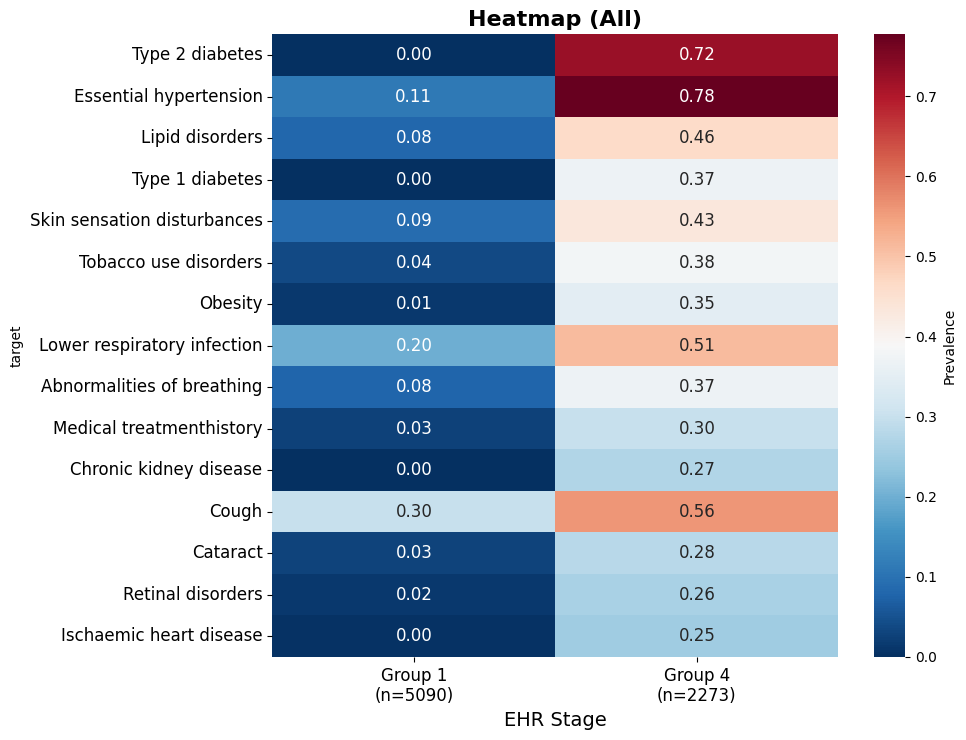

In [71]:
plot_heat_map_2(one_hot_encoded, result_df, all_codes[:15], plot_code, 0.1, title = 'All',
              save_title='consistly_heatmap_40_65')

In [118]:
# 1) Define the two masks for 40→45 transitions
def extract_tail(row):
    code_length = len(row['b4_code'])
    return row['code'][code_length:]

import pandas as pd
# --- ASSUMPTION ---
# You MUST have these functions/variables defined globally for this to work:
# spark, read_parquet, process_codes, extract_tail
# df_with_groups (or you must pass it when calling the function)
# --- END ASSUMPTION ---

def extract_tail(row):
    """Finds the tail of the code string."""
    code_length = len(row['b4_code'])
    return row['code'][code_length:]

# --- ASSUMPTION ---
# You MUST have these functions/variables defined globally for this to work:
# spark, read_parquet, process_codes, extract_tail
# --- END ASSUMPTION ---

def analyze_pre_vs_post_codes(df_groups, mask, age1, age2, group_label):
    """
    For a given group of patients (defined by mask):
    1. Gets all their codes at age1 (label = "_pre")
    2. Gets ONLY their new "tail" codes at age2 (label = "_post")
    3. Combines them into one dataframe for comparison.
    """
    
    # 1. Subset and get patids
    transition_group = df_groups.loc[mask].copy()
    patid_list = transition_group['patid'].tolist()
    print(f"Analyzing group '{group_label}': {len(patid_list)} patients")

    # 2. Load EHR data
    path_1 = f'EHR_age/40-65/{age1}_CPRD_incidence_EHR_TIME'
    ehr_age1 = pd.read_parquet(path_1)
    path_2 = f'EHR_age/40-65/{age2}_CPRD_incidence_EHR_TIME'
    ehr_age2 = pd.read_parquet(path_2)


    # 3. Filter Spark DFs and get Pandas DFs
    ehr_age1_pd = ehr_age1.filter(ehr_age1.patid.isin(patid_list)).toPandas()
    ehr_age2_pd = ehr_age2.filter(ehr_age2.patid.isin(patid_list)).toPandas()

    # 4. Create the "pre" dataframe
    # This has the full codes from age1
    df_pre = ehr_age1_pd[['patid', 'code']].copy()
    # df_pre['label'] = f"{group_label}_pre"
    df_pre['label'] = age1

    # 5. Create the "post" (tail) dataframe
    # Merge to get codes side-by-side
    df_merged = ehr_age1_pd.rename(columns={'code':'b4_code'}) \
                         .merge(ehr_age2_pd[['patid', 'code']], on='patid', how='inner')
    
    # Isolate ONLY the tail codes
    df_merged['post_code'] = df_merged.apply(lambda row: extract_tail(row), axis=1)
    
    # This dataframe has ONLY the tail codes
    df_post = df_merged[['patid', 'post_code']].copy()
    df_post.rename(columns={'post_code': 'code'}, inplace=True)
    # df_post['label'] = f"{group_label}_post"
    df_post['label'] = age2

    # 6. Combine Pre and Post dataframes
    result_df = pd.concat([df_pre, df_post], axis=0, ignore_index=True)
    
    # 7. One-hot encode the combined data
    # This dataframe now has two labels: "_pre" and "_post"
    result_df['processed_code'] = result_df['code'].apply(process_codes)
    all_codes = set(code for sublist in result_df['processed_code'] for code in sublist)
    one_hot_encoded = pd.DataFrame({code: result_df['processed_code'].apply(lambda x: code in x).astype(int) for code in all_codes})

    return result_df, one_hot_encoded

def get_significant_code(one_hot_encoded, result_df, variation_threshold=0.1, plot_code='icd'):
    
    # 1. Calculate significance
    proportion_ranges = one_hot_encoded.groupby(result_df['label']).mean().apply(lambda x: x.max() - x.min(), axis=0)

    # --- MODIFICATION ---
    # 2. Sort by significance (highest first)
    proportion_ranges = proportion_ranges.sort_values(ascending=False)
    
    # 3. Filter by threshold
    significant_codes_series = proportion_ranges[proportion_ranges > variation_threshold]
    significant_codes = significant_codes_series.index # Get the index (codes)
    # --- END MODIFICATION ---

    # The rest of your filtering logic can stay the same
    # Note: 'significant_codes' is now an Index object, not a list,
    # so we can apply filters directly.

    if plot_code == 'icd':
        significant_codes = significant_codes[significant_codes.str.len() == 3]
    elif plot_code == 'proc':
        significant_codes = significant_codes[significant_codes.str.startswith('PROC_')]
    elif plot_code == 'med':
        significant_codes = significant_codes[significant_codes.str.startswith('bnf_') | significant_codes.str.startswith('vtm_')]
    elif plot_code == 'val':
        significant_codes = significant_codes[significant_codes.str.startswith('VAL_')]
    elif plot_code == 'all':
        pass # Already have all
    else:
        assert plot_code in ['icd','proc','med','val','all']

    # We no longer need to sort alphabetically
    # significant_codes = pd.Index(sorted(significant_codes))
    
    v = significant_codes.map(map_to_target)
    
    # This will now be sorted by significance
    mappinged_v = {}
    for i in range(len(v)):
        if pd.isna(v[i]): # Handle codes not in map_to_target
            continue
        mappinged_v[v[i]] = significant_codes[i]
        
    # return mappinged_v, significant_codes_series.loc[significant_codes] # Also return the scores
    return mappinged_v


def plot_heat_map(one_hot_encoded, result_df, significant_codes, plot_code='icd', variation_threshold=0.15, 
                  title = '40 to 45, worse',save_title='40_45_1_4',cmap='RdBu_r', sort_by=(40, 45)):
    # 1) Build the prevalence matrix
    co_matrix = (one_hot_encoded[significant_codes].groupby(result_df['label']).mean().T)
    # co_matrix.columns might be strings like '40','45'
    # force them to ints
    co_matrix.columns = co_matrix.columns.astype(int)
    co_matrix.index = co_matrix.index.map(map_to_target)
    co_matrix = co_matrix.rename_axis(index='target')
    label_counts = result_df['label'].astype(int).value_counts().sort_index()
    # label_counts = result_df['label'].value_counts().sort_index()

    xticks = [f"{lbl}\n(n={label_counts.get(lbl,0)})" for lbl in co_matrix.columns]

    start, end = sort_by
    diff = co_matrix[end] - co_matrix[start]
    co_matrix['__diff__'] = diff
    co_matrix = co_matrix.sort_values('__diff__', ascending=False)
    co_matrix.drop(columns='__diff__', inplace=True)

    plt.figure(figsize=(10, len(co_matrix)/2), dpi=100)
    sns.heatmap(co_matrix, cmap=cmap, annot=True,fmt=".2f",annot_kws={'size':12},cbar_kws={'label':'Prevalence'})

    # 5) Axes formatting
    plt.xlabel('EHR Stage', fontsize=14)
    # y_labels = [lbl[:50] for lbl in co_matrix.index]
    y_labels = [lbl[:50].capitalize()  for lbl in co_matrix.index]

    plt.yticks(ticks=np.arange(len(y_labels)) + 0.5, labels=y_labels, fontsize=12, rotation=0, ha='right')
    plt.xticks(ticks=np.arange(len(xticks)) + 0.5, labels=xticks, fontsize=12, rotation=0, ha='center')
    plt.title(f'Heatmap ({title})', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # 6) Save & show
    outdir = os.path.join(save_path, 'heatmap')
    os.makedirs(outdir, exist_ok=True)
    plt.savefig(os.path.join(save_path, 'heatmap', 'age_trand_'+ f'{save_title}_thred_{variation_threshold}_{plot_code}.pdf'))
    plt.show()


In [121]:
age1 = 40
age2 = 45
mask_1_to_4 = (df_with_groups[f'grp_{age1}'] == 0) & (df_with_groups[f'grp_{age2}'] == 3)
result_df, one_hot_encoded = analyze_pre_vs_post_codes(df_with_groups,  mask_1_to_4, age1, age2, 
    group_label="1->4")
plot_code= 'icd' # 'icd', 'proc', 'med', 'val', 'all'
significant_code= get_significant_code(one_hot_encoded, result_df, 0.05, plot_code)
all_codes = [v for k, v in significant_code.items()]
print(len(all_codes))
all_codes = [code for code in all_codes if code not in ['E14','Z86']][:15]
plot_heat_map(one_hot_encoded, result_df,all_codes, plot_code, 0.1, title = '40 to 45, worse',
              save_title='40_45_worse', sort_by=(40, 45))

Analyzing group '1->4': 1877 patients


In [124]:
age1 = 45
age2 = 50
mask_1_to_4 = (df_with_groups[f'grp_{age1}'] == 0) & (df_with_groups[f'grp_{age2}'] == 3)
result_df, one_hot_encoded = analyze_pre_vs_post_codes(df_with_groups,  mask_1_to_4, age1, age2, 
    group_label="1->4")

Analyzing group '1->4': 1106 patients


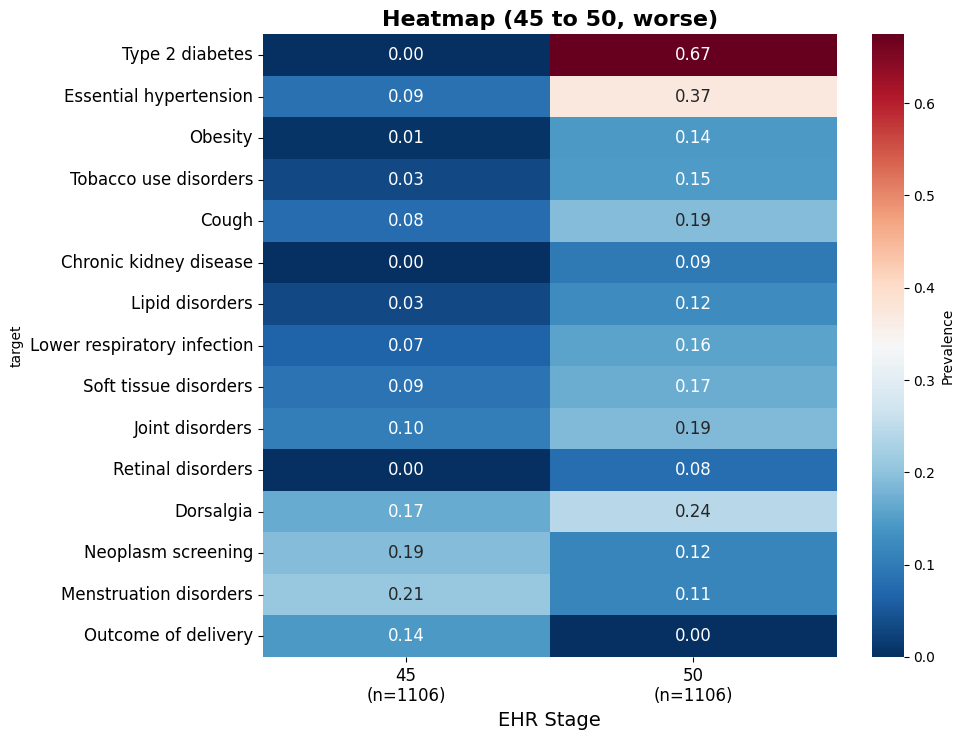

In [125]:
plot_code= 'icd' # 'icd', 'proc', 'med', 'val', 'all'
significant_code= get_significant_code(one_hot_encoded, result_df, 0.05, plot_code)
all_codes = [v for k, v in significant_code.items()]
# all_codes = [code for code in all_codes if code != 'E14'][:15]
all_codes = [code for code in all_codes if code not in ['E14','Z86']][:15]
plot_heat_map(one_hot_encoded, result_df,all_codes, plot_code, 0.05, title = '45 to 50, worse',save_title='45_50_worse', sort_by=(45, 50))

In [126]:
age1 = 50
age2 = 55
mask_1_to_4 = (df_with_groups[f'grp_{age1}'] == 0) & (df_with_groups[f'grp_{age2}'] == 3)
result_df, one_hot_encoded = analyze_pre_vs_post_codes(df_with_groups,  mask_1_to_4, age1, age2, 
    group_label="1->4")
significant_code= get_significant_code(one_hot_encoded, result_df, 0.05, plot_code)
all_codes = [v for k, v in significant_code.items()]
all_codes = [code for code in all_codes if code not in ['E14','Z86']][:15]
plot_heat_map(one_hot_encoded, result_df,all_codes, plot_code, 0.05, title = '50 to 55, worse',
              save_title='50_55_1_4', sort_by=(50, 55))

Analyzing group '1->4': 502 patients


In [130]:
age1 = 55
age2 = 60
mask_1_to_4 = (df_with_groups[f'grp_{age1}'] == 0) & (df_with_groups[f'grp_{age2}'] == 3)
result_df, one_hot_encoded = analyze_pre_vs_post_codes(df_with_groups,  mask_1_to_4, age1, age2, 
    group_label="1->4")
significant_code= get_significant_code(one_hot_encoded, result_df, 0.05, plot_code)
all_codes = [v for k, v in significant_code.items()]
all_codes = [code for code in all_codes if code not in ['E14','Z86']][:15]
plot_heat_map(one_hot_encoded, result_df,all_codes, plot_code, 0.05, title = '55 to 60, worse',
              save_title='55_60_1_4', sort_by=(55, 60))

Analyzing group '1->4': 191 patients
